In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats 
from scipy.stats import shapiro 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("out.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1268 non-null   int64  
 1   id                    1268 non-null   object 
 2   date                  1268 non-null   object 
 3   activity              1268 non-null   float64
 4   circumplex.arousal    1268 non-null   float64
 5   circumplex.valence    1268 non-null   float64
 6   mood                  1268 non-null   float64
 7   appCat.builtin        1268 non-null   float64
 8   appCat.communication  1268 non-null   float64
 9   appCat.entertainment  1268 non-null   float64
 10  appCat.finance        1268 non-null   float64
 11  appCat.game           1268 non-null   float64
 12  appCat.office         1268 non-null   float64
 13  appCat.other          1268 non-null   float64
 14  appCat.social         1268 non-null   float64
 15  appCat.travel        

In [4]:
df.columns.tolist()

['Unnamed: 0',
 'id',
 'date',
 'activity',
 'circumplex.arousal',
 'circumplex.valence',
 'mood',
 'appCat.builtin',
 'appCat.communication',
 'appCat.entertainment',
 'appCat.finance',
 'appCat.game',
 'appCat.office',
 'appCat.other',
 'appCat.social',
 'appCat.travel',
 'appCat.unknown',
 'appCat.utilities',
 'appCat.weather',
 'call',
 'screen',
 'sms']

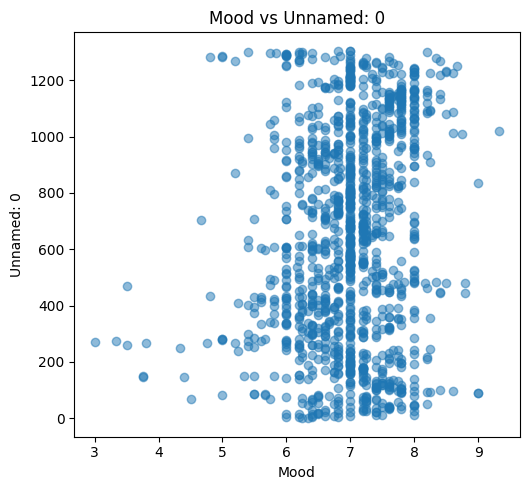

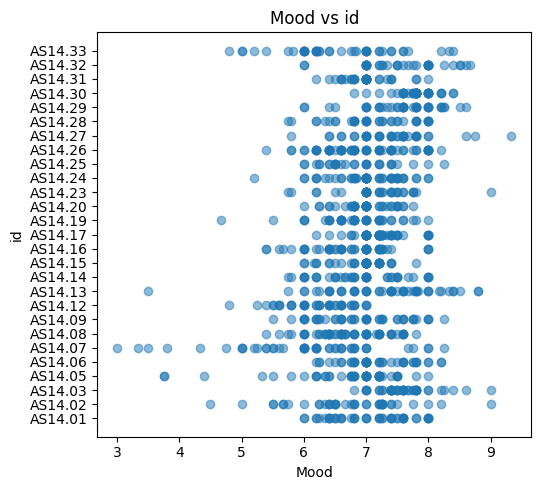

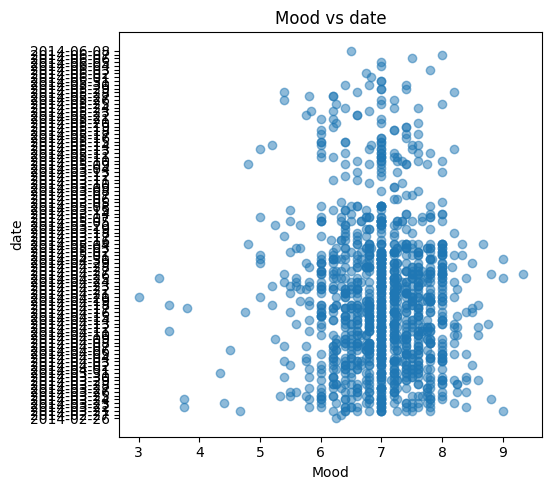

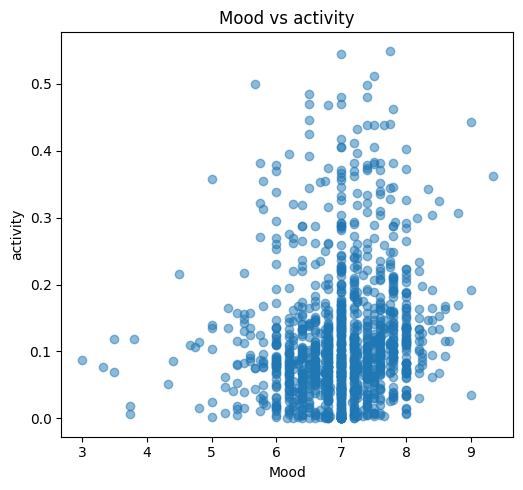

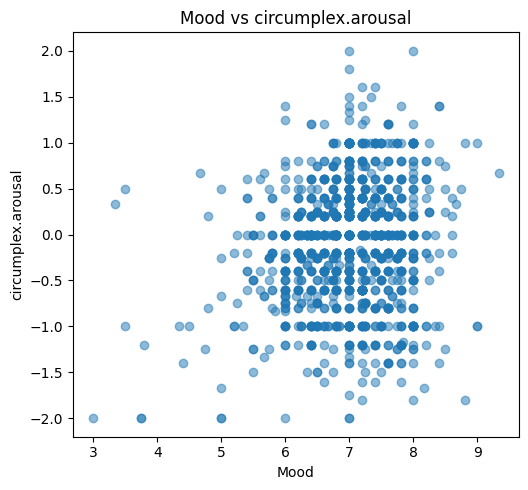

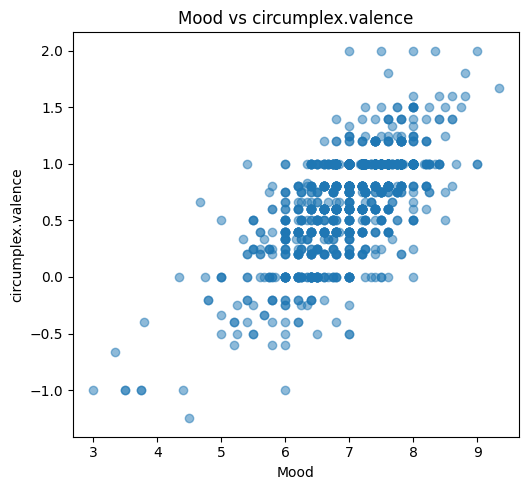

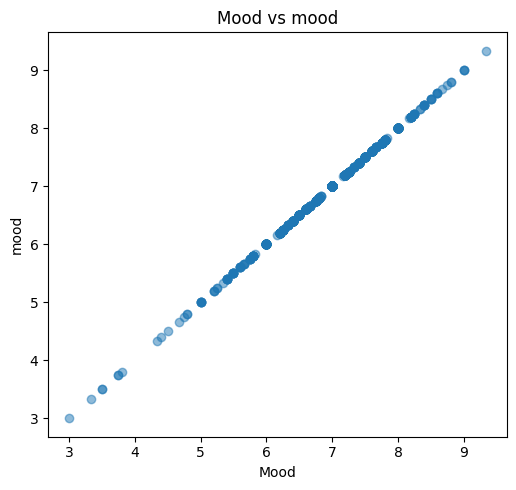

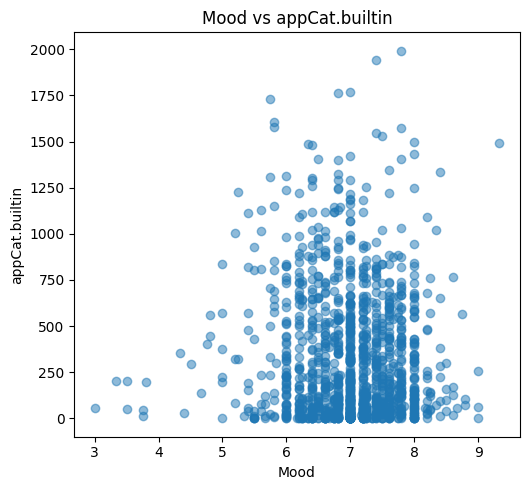

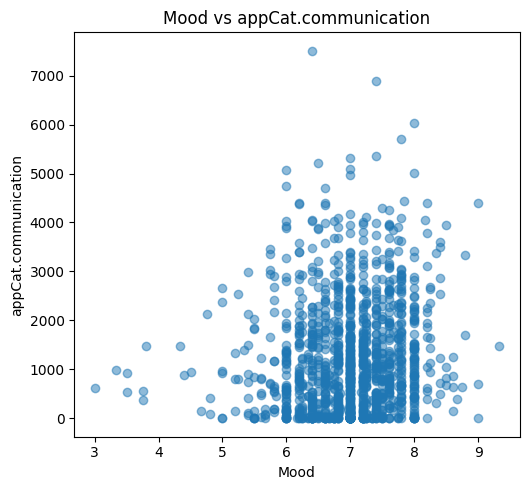

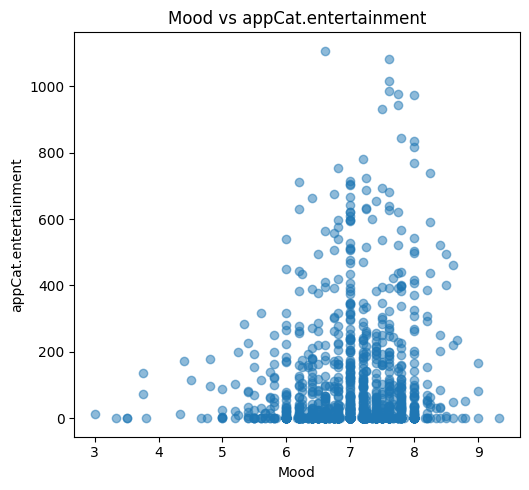

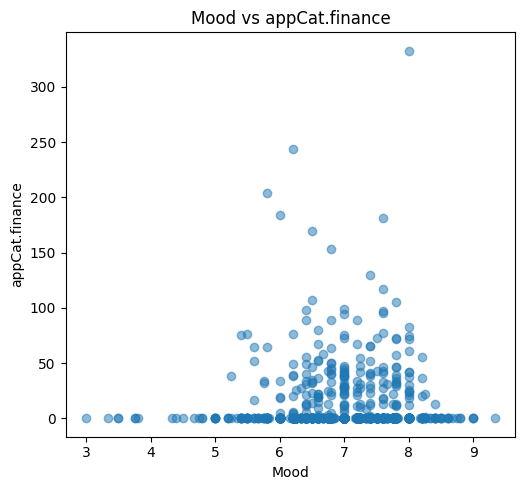

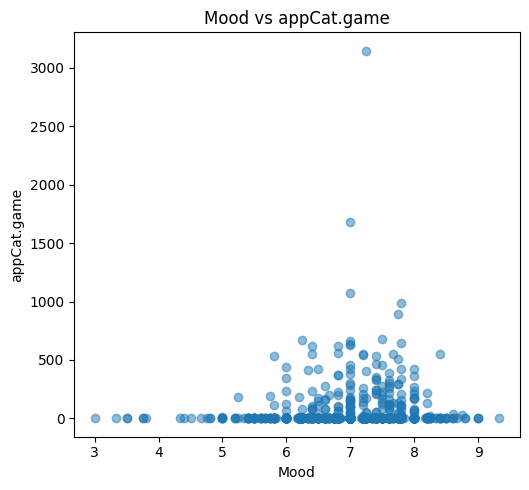

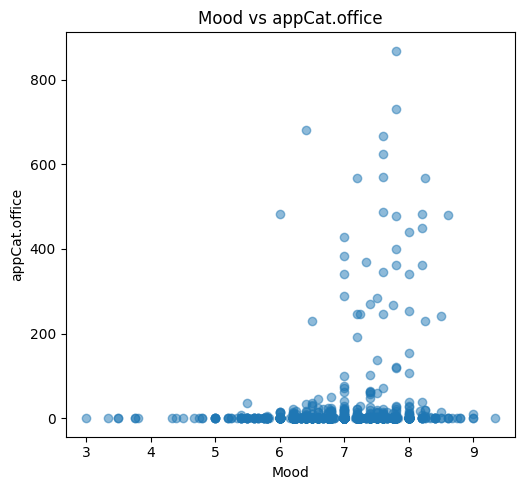

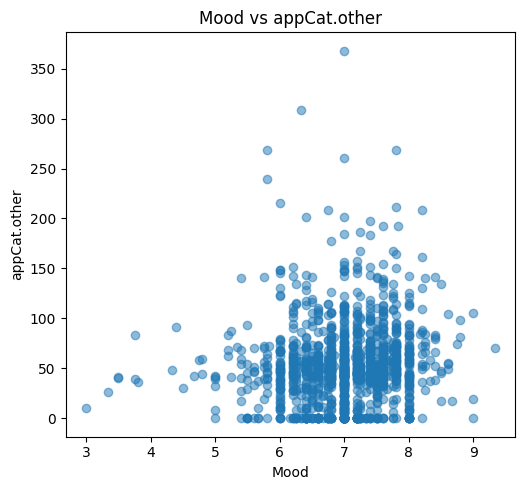

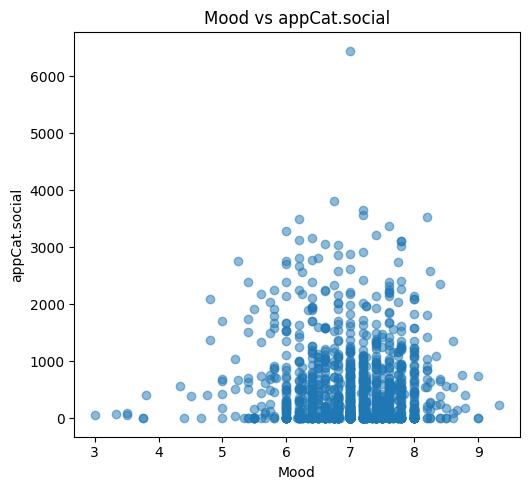

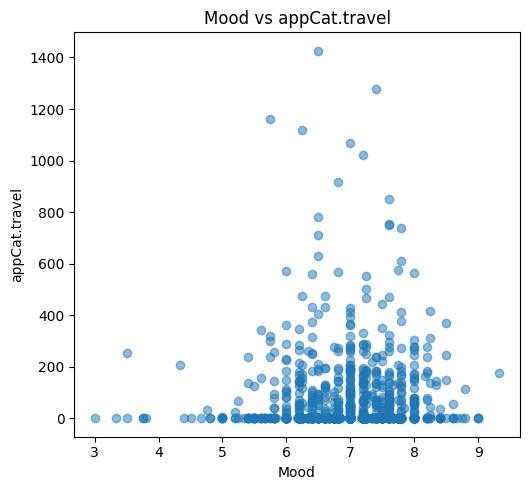

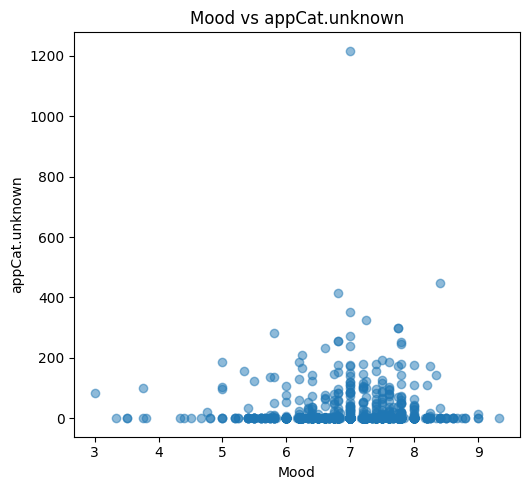

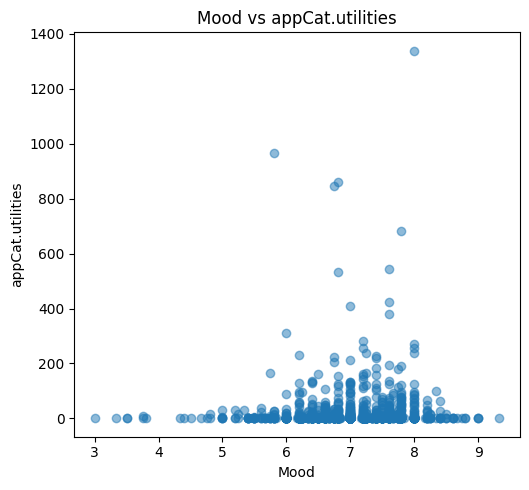

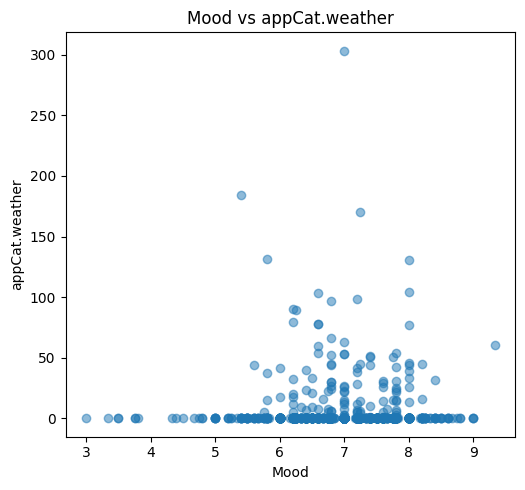

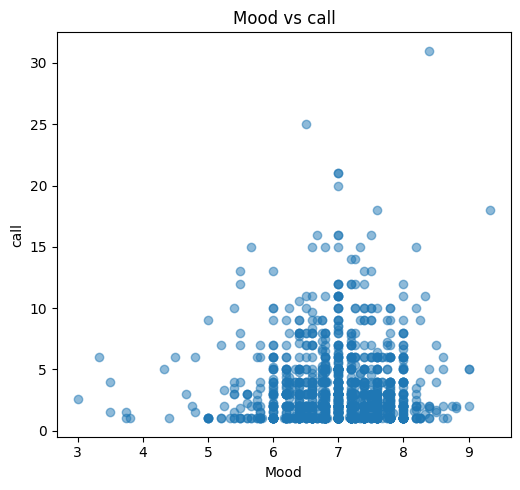

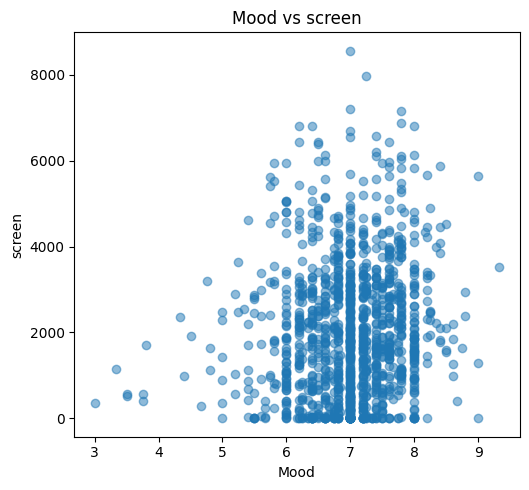

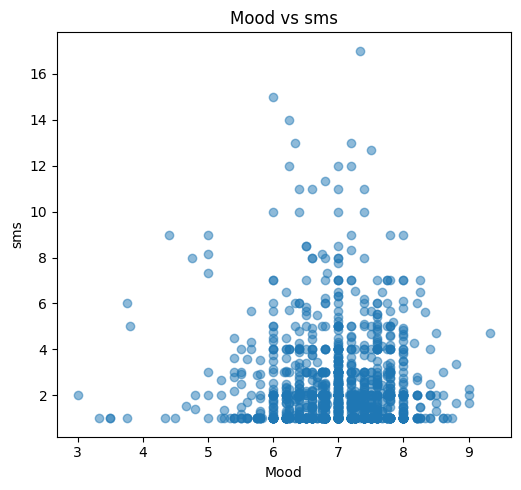

In [5]:
def plots(data):
    for column in df:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 2)
        plt.scatter(df['mood'], df[column], alpha=0.5)
        plt.title('Mood vs ' + column)
        plt.xlabel('Mood')
        plt.ylabel(column)

        plt.tight_layout()
        plt.show()
plots(df)

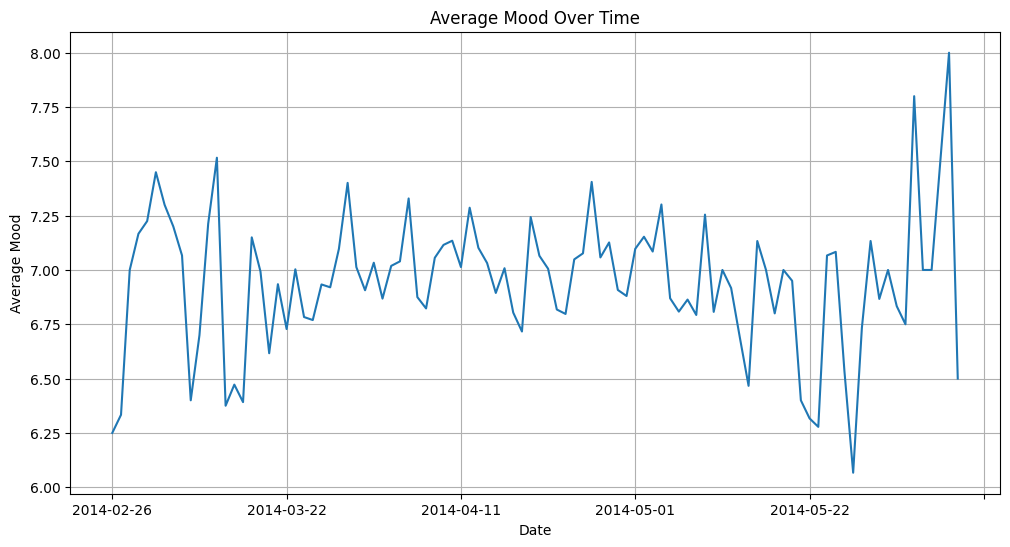

In [6]:
plt.figure(figsize=(12, 6))
df.groupby('date')['mood'].mean().plot(title='Average Mood Over Time')
plt.xlabel('Date')
plt.ylabel('Average Mood')
plt.grid(True)
plt.show()

<Figure size 2000x2000 with 0 Axes>

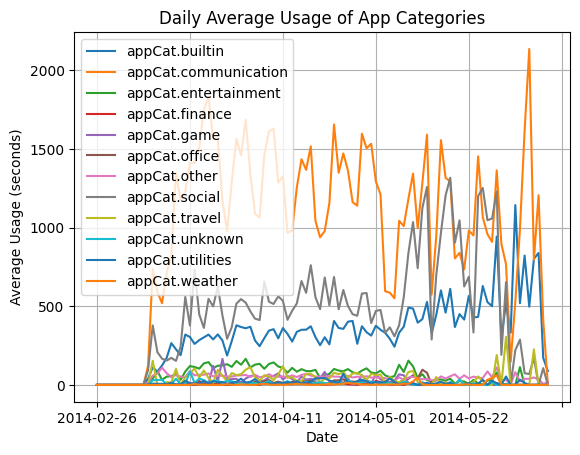

In [7]:
# Daily average usage of different app categories
app_categories = ['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 
                  'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 
                  'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']
plt.figure(figsize=(20, 20))
df.groupby('date')[app_categories].mean().plot(title='Daily Average Usage of App Categories')
plt.xlabel('Date')
plt.ylabel('Average Usage (seconds)')
#plt.legend(title='App Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Colinearity

In [8]:
def calculate_vif(data):
    # Adding a constant for intercept
    X = data.assign(const=1)
    vifs = pd.DataFrame()
    vifs["Variable"] = X.columns
    vifs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vifs.drop(index=vifs[vifs['Variable'] == 'const'].index)  # Removing the constant term

col_df = df[['activity', 'circumplex.arousal','circumplex.valence', 'mood', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 
                  'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 
                  'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'screen', 'call', 'sms']]
# Calculate VIF for the heatmap_data
vif_df = calculate_vif(col_df)
vif_df


,Variable,VIF
0,activity,1.364366
1,circumplex.arousal,1.096799
2,circumplex.valence,2.142237
3,mood,2.147373
4,appCat.builtin,3.030066
5,appCat.communication,4.727242
6,appCat.entertainment,1.474028
7,appCat.finance,1.184221
8,appCat.game,1.115785
9,appCat.office,1.544953


The most common measure to test for multicollinearity is the Variance Inflation Factor (VIF), which quantifies how much the variance of an estimated regression coefficient increases if predictors are correlated. If no factors are correlated, the VIFs will be 1.

- **Activiy** low
- **Arousal** low
- **Valence** moderate
- **Mood** no multicollinearity concerns with mood.
- *App Category Built-in*: a low level of multicollinearity.
- *App Category Communication*:  a moderate level, suggesting some correlation with other variables.
- **App Category Entertainment**: very low, indicating minimal multicollinearity.
- **App Category Social**: also very low.
- **App Category Utilities**: very low.
- *Screen Time*: higher and might indicate a considerable degree of multicollinearity.
- **Calls**: very low.
- **SMS**: very low.

The most significant finding here is the VIF for screen time, which is relatively high compared to the other variables. This suggests that screen time might be correlated with several other features, potentially distorting analyses that involve this variable. For regression analyses, you might consider checking the specific relationships involving screen time or applying techniques to reduce multicollinearity.

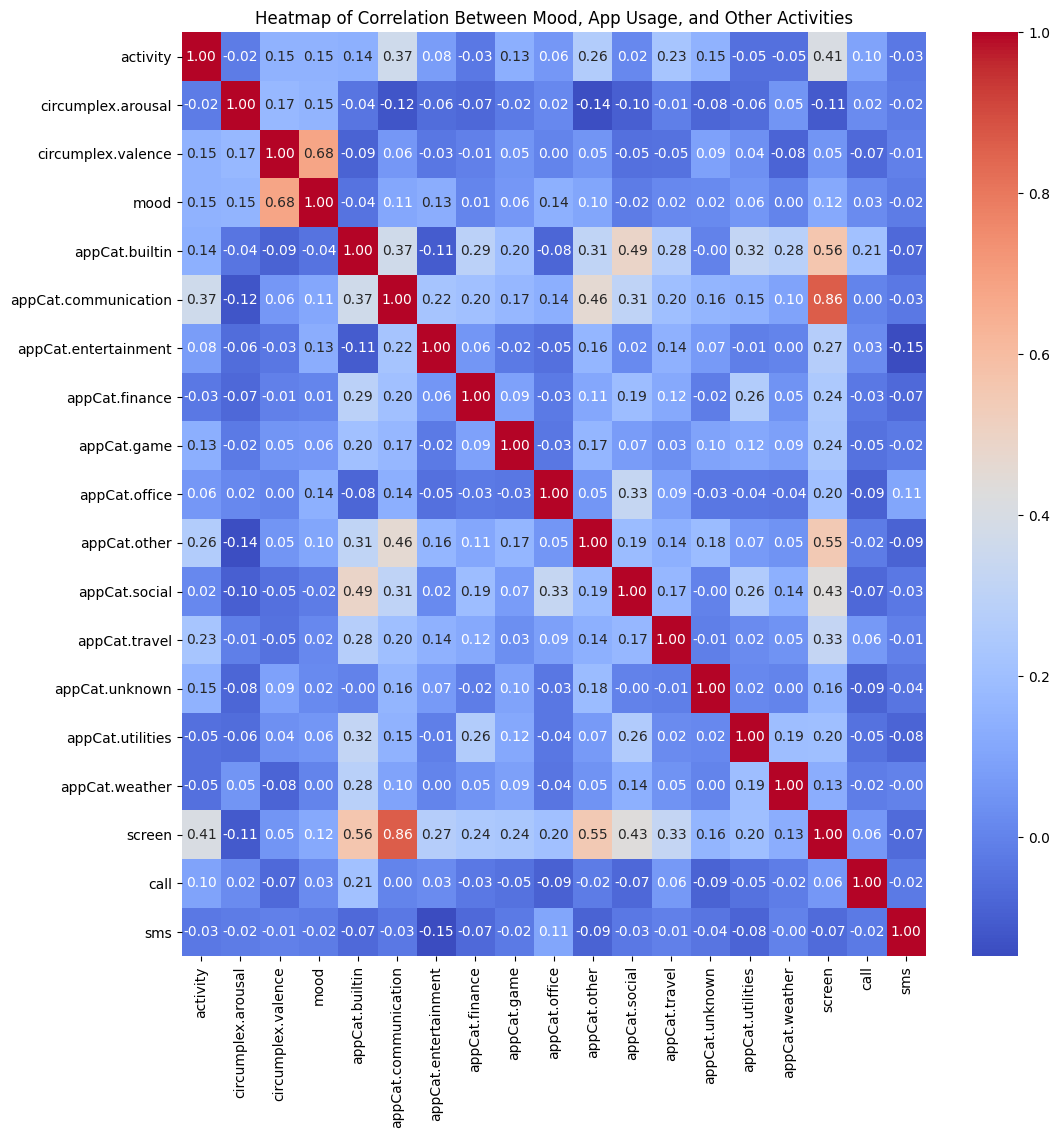

In [9]:
def cor_map(data):    
    corr = data.corr()
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Heatmap of Correlation Between Mood, App Usage, and Other Activities')
    plt.show()

cor_map(col_df)

## No Screen

In [10]:
df1 = df.drop('screen', axis = 1)

In [11]:
df1.head()

,Unnamed: 0,id,date,activity,circumplex.arousal,circumplex.valence,mood,appCat.builtin,appCat.communication,appCat.entertainment,...,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,sms
0,0,AS14.01,2014-02-26,0.081548,-0.25,0.750000,6.250000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,1.0,2.00
1,1,AS14.01,2014-02-27,0.081548,0.00,0.333333,6.333333,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,1.0,1.75
2,3,AS14.01,2014-03-21,0.134050,0.20,0.200000,6.200000,1090.617,2850.042,100.898,...,0.0,5.479,50.465,3121.747,167.373,0.0,229.138,0.000,6.0,1.25
3,4,AS14.01,2014-03-22,0.236880,0.60,0.500000,6.400000,476.737,1946.683,4.010,...,0.0,0.000,60.565,439.632,37.305,0.0,53.188,0.000,3.0,1.00
4,5,AS14.01,2014-03-23,0.142741,0.20,0.800000,6.800000,540.915,2680.535,4.028,...,0.0,0.000,40.604,649.414,0.000,0.0,30.086,30.386,6.5,1.00


In [12]:
y = df1['mood']                          
list = ['Unnamed: 0','id','date','mood']
x = df1.drop(list,axis = 1 )
x

,activity,circumplex.arousal,circumplex.valence,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,sms
0,0.081548,-0.250000,0.750000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.000000
1,0.081548,0.000000,0.333333,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.750000
2,0.134050,0.200000,0.200000,1090.617,2850.042,100.898,49.544,0.0,5.479,50.465,3121.747,167.373,0.000,229.138,0.000,6.0,1.250000
3,0.236880,0.600000,0.500000,476.737,1946.683,4.010,21.076,0.0,0.000,60.565,439.632,37.305,0.000,53.188,0.000,3.0,1.000000
4,0.142741,0.200000,0.800000,540.915,2680.535,4.028,43.403,0.0,0.000,40.604,649.414,0.000,0.000,30.086,30.386,6.5,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,0.012704,-0.600000,0.400000,269.550,771.182,32.137,0.000,0.0,0.000,57.535,1252.079,0.000,0.000,56.173,0.000,1.0,2.000000
1264,0.103301,0.000000,1.200000,1093.741,1057.568,153.121,0.000,0.0,38.262,208.962,1817.695,0.000,0.000,30.666,0.000,10.0,1.000000
1265,0.169354,-1.333333,1.000000,248.063,198.112,5.018,0.000,0.0,0.000,29.202,377.179,0.939,0.000,3.199,0.000,5.0,1.000000
1266,0.192901,-0.800000,-0.400000,930.885,992.321,21.178,0.000,0.0,0.000,52.610,1706.765,915.714,8.072,155.922,0.000,4.0,1.000000


In [13]:
x.describe()

,activity,circumplex.arousal,circumplex.valence,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,sms
count,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000
mean,0.116797,-0.103851,0.686028,325.233632,1233.642027,92.153095,6.587916,32.771612,14.495484,53.100360,512.084566,53.696357,14.521868,19.032430,3.290161,3.394880,2.378634
std,0.096232,0.662715,0.435115,346.181256,1136.017283,168.118482,22.752900,144.214235,74.468358,41.124215,697.240145,134.830670,55.436727,75.267376,16.484121,3.064657,1.975129
min,0.000000,-2.000000,-1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.053631,-0.600000,0.400000,54.857250,311.316500,0.000000,0.000000,0.000000,0.000000,29.224000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.093636,0.000000,0.800000,199.598500,973.873000,13.923000,0.000000,0.000000,0.000000,48.840500,228.886500,0.000000,0.000000,0.000000,0.000000,2.333333,1.800000
75%,0.146528,0.400000,1.000000,509.491000,1817.872000,103.925750,0.000000,0.000000,0.000000,69.099500,729.127500,47.207000,0.000000,7.258500,0.000000,4.000000,3.000000
max,0.549430,2.000000,2.000000,1992.500000,7508.426000,1106.638000,332.848000,3148.001000,868.184000,367.903000,6450.558000,1426.296000,1216.493000,1338.834000,303.357000,31.000000,17.000000


In [14]:
y.value_counts()

7.000000    233
7.200000     97
6.800000     81
8.000000     73
7.400000     73
7.600000     67
6.400000     62
6.600000     60
7.800000     59
6.000000     55
7.500000     48
6.200000     44
7.250000     41
6.500000     35
6.750000     33
7.750000     24
6.250000     20
8.200000     13
5.800000     13
6.333333     11
5.500000      9
7.666667      9
6.666667      9
5.400000      8
7.333333      8
8.250000      7
8.400000      7
5.750000      7
5.600000      6
5.000000      6
5.666667      4
8.600000      4
8.500000      4
6.833333      3
5.200000      3
9.000000      3
8.333333      2
3.500000      2
4.800000      2
8.800000      2
5.250000      2
3.750000      2
4.333333      1
8.666667      1
9.333333      1
8.750000      1
4.666667      1
6.166667      1
4.500000      1
8.166667      1
7.833333      1
7.166667      1
3.333333      1
4.400000      1
3.000000      1
5.333333      1
3.800000      1
4.750000      1
5.833333      1
Name: mood, dtype: int64

In [15]:
vif_df1 = calculate_vif(x)
vif_df1

,Variable,VIF
0,activity,1.319272
1,circumplex.arousal,1.094103
2,circumplex.valence,1.113537
3,appCat.builtin,2.379894
4,appCat.communication,1.680919
5,appCat.entertainment,1.230383
6,appCat.finance,1.183795
7,appCat.game,1.091607
8,appCat.office,1.325915
9,appCat.other,1.403710


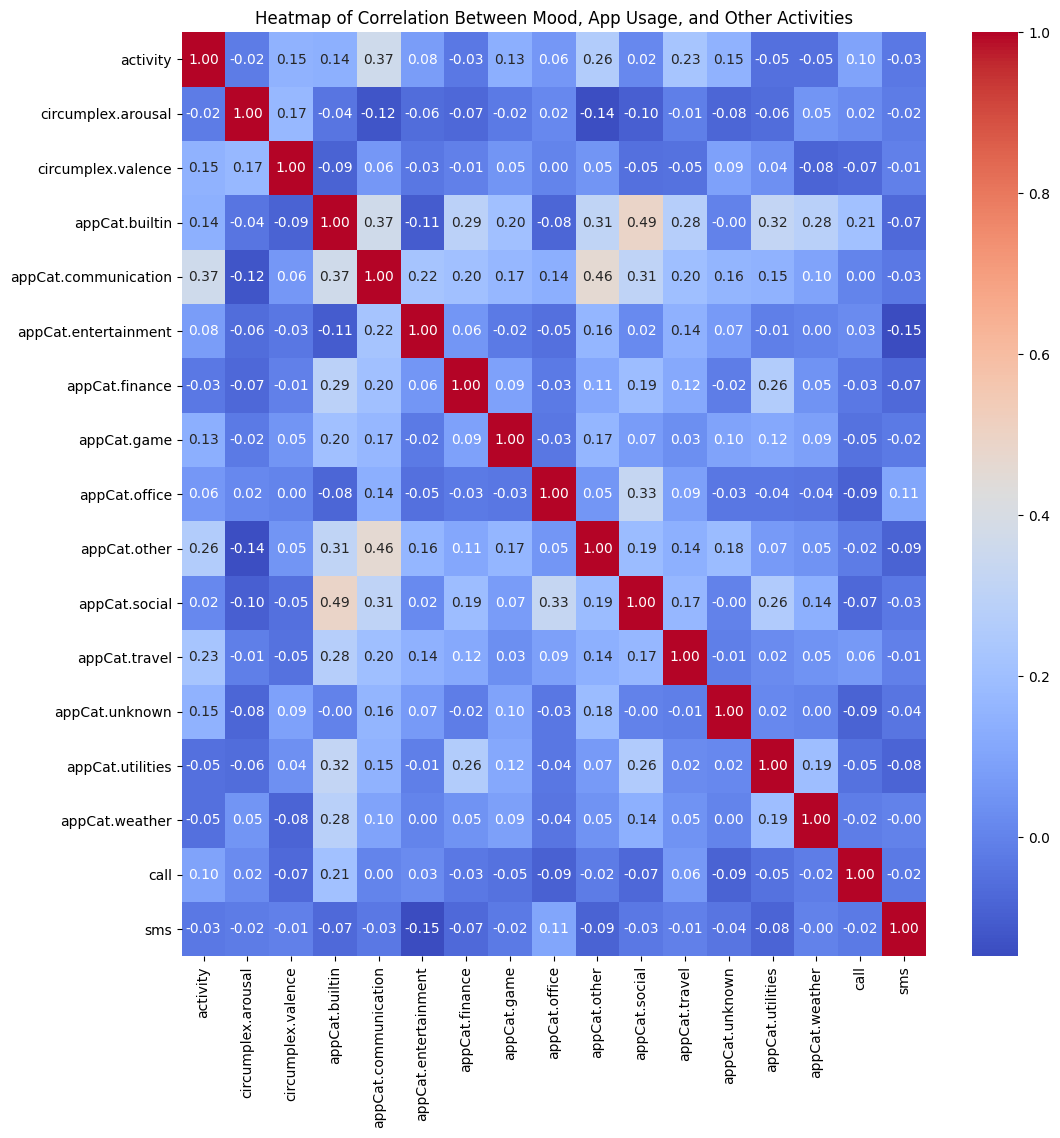

In [16]:
cor_map(x)

In [17]:
# Filter the correlation matrix to find pairs with correlation greater than 0.30, excluding the diagonal (self-correlation)
corr = df1.corr()
high_corr = corr.abs().unstack()
high_corr = high_corr[high_corr >= 0.3]
high_corr = high_corr[high_corr < 1.0]  # Exclude self-correlation (which is always 1)
high_corr = high_corr.sort_values(ascending=False)

# Remove duplicates (since matrix is symmetric)
high_corr = high_corr.reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr = high_corr.loc[high_corr['Variable 1'] < high_corr['Variable 2']]

high_corr


,Variable 1,Variable 2,Correlation
1,circumplex.valence,mood,0.681645
3,appCat.builtin,appCat.social,0.493164
4,appCat.communication,appCat.other,0.458364
7,appCat.builtin,appCat.communication,0.369076
8,activity,appCat.communication,0.367034
10,appCat.office,appCat.social,0.328078
12,appCat.builtin,appCat.utilities,0.320676
15,appCat.builtin,appCat.other,0.310238
16,appCat.communication,appCat.social,0.306400


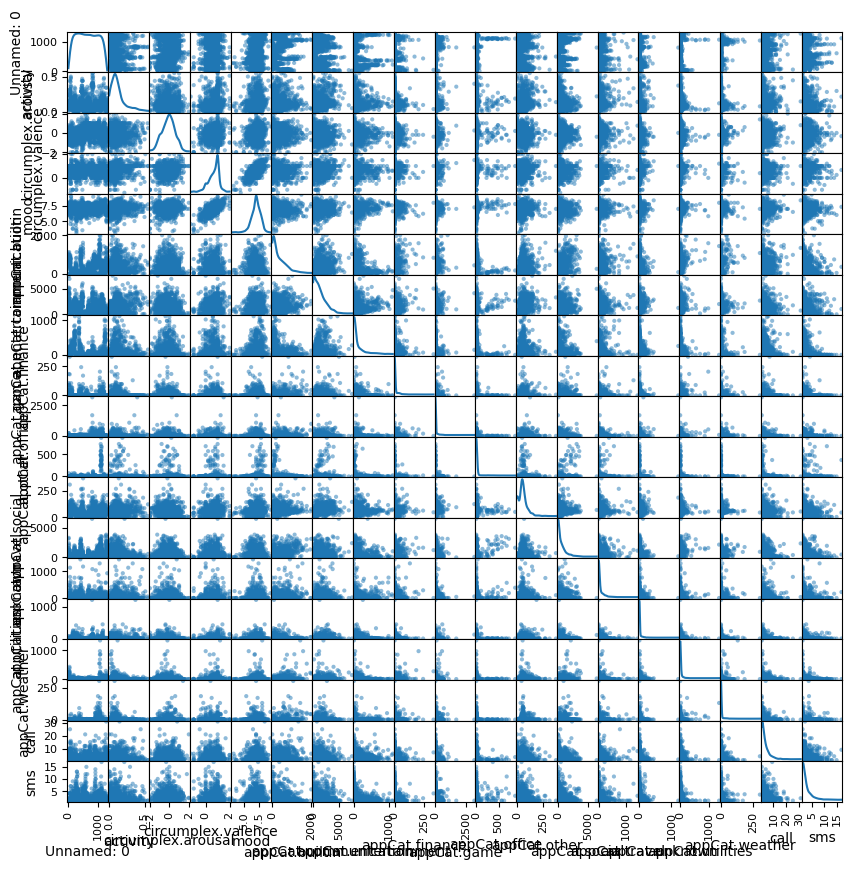

In [18]:
pd.plotting.scatter_matrix(df1, figsize=(10, 10), diagonal='kde')
plt.show()

# Normality- spoiler : not normal

In [19]:
stat, p = shapiro(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.341, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\ilinc\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


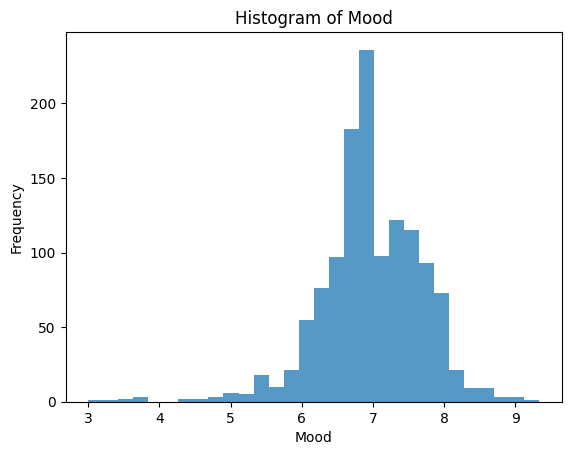

In [20]:
import matplotlib.pyplot as plt

# Plotting a histogram of the 'mood' column
plt.hist(df1['mood'], bins=30, alpha=0.75)
plt.title('Histogram of Mood')
plt.xlabel('Mood')
plt.ylabel('Frequency')
plt.show()


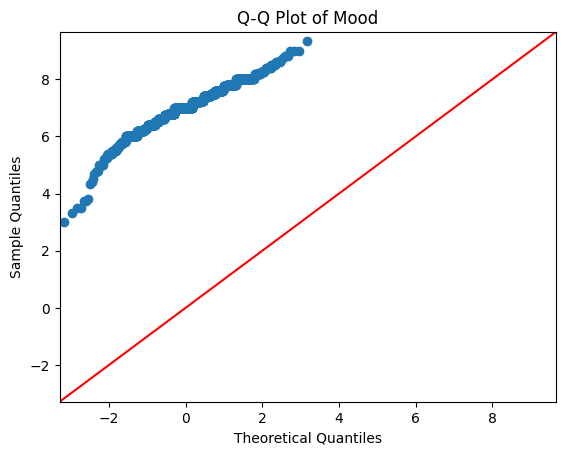

In [21]:
sm.qqplot(y, line ='45')
plt.title('Q-Q Plot of Mood')
plt.show()

# Simple LR Model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((887, 17), (381, 17), (887,), (381,))

In [23]:
x.shape,y.shape

((1268, 17), (1268,))

In [24]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [25]:
accuracy = regressor.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.4641249340906374


# Regularization

## Ridge

In [26]:
from sklearn.linear_model import RidgeCV
import numpy as np

# Define a range of alpha values
alphas = np.logspace(-6, 6, 100)

# Set up the RidgeCV to perform internal cross-validation
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

print("Optimal alpha:", ridge_cv.alpha_)

Optimal alpha: 2.009233002565046


In [27]:
# Assuming X_train, X_test, y_train, y_test are already defined
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train, y_train)

Ridge(alpha=2.009233002565046)

In [28]:
ridge_coefficients = ridge_model.coef_

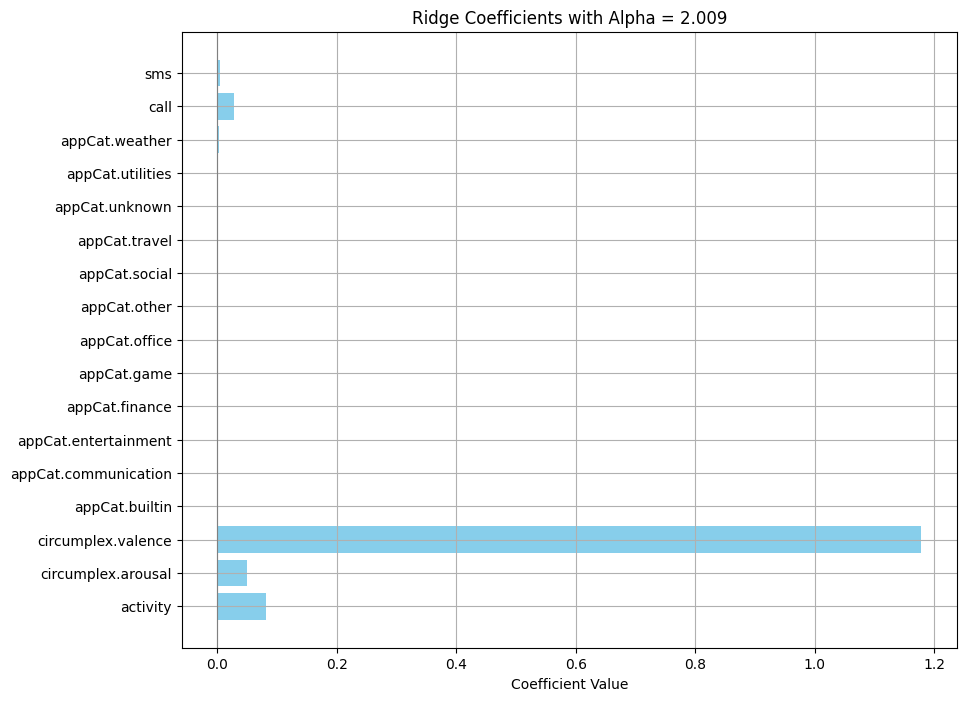

In [29]:
import matplotlib.pyplot as plt

# Plotting the coefficients using the column names from X_train
plt.figure(figsize=(10, 8))
y_pos = range(len(X_train.columns))

plt.barh(y_pos, ridge_coefficients, align='center', color='skyblue')
plt.yticks(y_pos, X_train.columns)
plt.xlabel('Coefficient Value')
plt.title('Ridge Coefficients with Alpha = 2.009')
plt.axvline(0, color='grey', linewidth=0.8)
plt.grid(True)
plt.show()


In [30]:
accuracy = ridge_model.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.4650154858279918


## Lasso

In [31]:
from sklearn.linear_model import LassoCV
import numpy as np

# Define a range of alpha values
alphas = np.logspace(-6, 1, 100)

# Set up the LassoCV to perform internal cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

print("Optimal alpha:", lasso_cv.alpha_)

Optimal alpha: 0.0024770763559917087


In [32]:
# Initialize Lasso regression with a specific alpha (e.g., 0.01)
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X_train, y_train)

# Coefficients from the model
lasso_coefficients = lasso.coef_

In [33]:
# List variables to keep and remove
variables_to_keep = x.columns[lasso_coefficients != 0].tolist()
variables_to_remove = x.columns[lasso_coefficients == 0].tolist()

print("Variables to Keep:", variables_to_keep)
print("Variables to Remove:", variables_to_remove)

Variables to Keep: ['circumplex.arousal', 'circumplex.valence', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'sms']
Variables to Remove: ['activity']


In [34]:
accuracy = lasso.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.4652123705564638


# Backwards Feature Selection

In [35]:
def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]  # Exclude intercept
        max_p_value = p_values.max()
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            print("We remove "+ excluded_feature)
        else:
            break
    return features

selected_features = backward_elimination(x, y)
print(selected_features)

We remove appCat.finance
We remove sms
We remove appCat.travel
We remove appCat.communication
We remove activity
We remove appCat.builtin
We remove appCat.game
We remove circumplex.arousal
['circumplex.valence', 'appCat.entertainment', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call']


## Forwards Feature Selection

In [36]:
#del list

In [47]:
import pandas as pd
import statsmodels.api as sm

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        # Explicitly specify the dtype to float
        new_pval = pd.Series(index=remaining_features, dtype='float')
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

# Assuming 'x' is your feature DataFrame and 'y' is your target variable
selected_features = forward_selection(x, y)
print(selected_features)


['circumplex.valence', 'appCat.entertainment', 'appCat.office', 'call', 'appCat.weather', 'appCat.social', 'appCat.builtin', 'appCat.unknown']


# Forest Regressor for Feature Selection

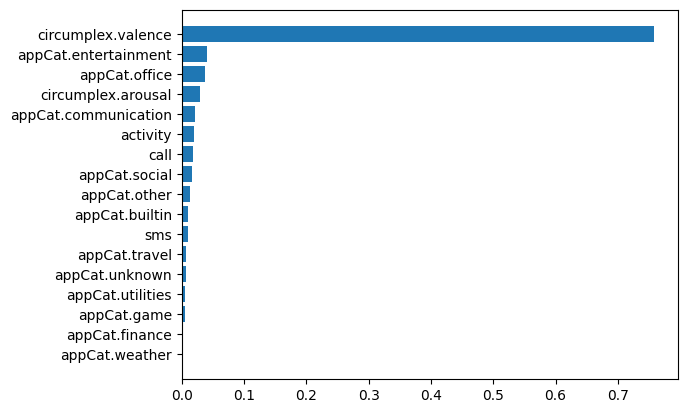

In [38]:
forest = RandomForestRegressor(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)
imp = {'Feature': X_train.columns.tolist(),'Importance':forest.feature_importances_ *100}
randomforest_features = pd.DataFrame(imp).sort_values(by='Importance', ascending=False)
f_i = list(zip(X_train.columns.tolist(),forest.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()

In [39]:
from boruta import BorutaPy

rf =  RandomForestRegressor(n_estimators=100, max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

feat_selector.fit(X_train.values, y_train)

print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	9
Iteration:

In [40]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
'Ranking':feat_selector.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
8,appCat.office,1
1,circumplex.arousal,1
2,circumplex.valence,1
4,appCat.communication,1
5,appCat.entertainment,1
15,call,1
10,appCat.social,2
0,activity,2
9,appCat.other,3
3,appCat.builtin,4


# Search best model

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),
                              columns = X_train.columns)
X_train_scaled.head()

,activity,circumplex.arousal,circumplex.valence,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,sms
0,0.747999,0.471518,0.752513,-0.412578,1.334290,-0.559851,-0.285945,-0.204577,11.22263,-0.076887,1.716737,2.250144,-0.314847,-0.277247,-0.191852,-0.002386,0.32059
1,-1.121730,-1.332090,-0.404631,-0.465461,-1.054484,-0.559851,-0.285945,0.974586,-0.19132,-0.022132,-0.739862,-0.379376,-0.314847,-0.277247,-0.191852,-0.751394,-0.68021
2,0.192336,1.298172,0.173941,-0.445339,-0.135147,2.367487,-0.285945,-0.204577,-0.19132,-0.088760,-0.739862,1.313216,-0.314847,-0.277247,-0.191852,1.227327,-0.34661
3,-0.509786,0.471518,-0.983202,1.011930,-0.208465,-0.345182,-0.285945,-0.204577,-0.19132,0.316971,-0.569681,0.024994,-0.314847,0.063213,-0.191852,1.898080,-0.68021
4,1.169214,2.275127,0.289655,-0.195377,-0.512062,-0.559851,-0.285945,-0.204577,-0.19132,1.281202,-0.739862,0.052909,-0.314847,-0.277247,-0.191852,1.227327,0.32059


In [42]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
Model = []
RMSE = []
R_sq = []
cv = KFold(5)

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor']
models = [LinearRegression(), Ridge(), Lasso(),
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor()]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, X_train_scaled, y_train)

In [46]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,RMSE,R Squared
0,Linear Regression,0.512472,0.516710
1,Ridge Regression,0.512435,0.516789
2,Lasso Regression,0.744487,-0.003200
3,K Neighbors Regressor,0.582810,0.374454
4,Decision Tree Regressor,0.713401,0.069494
5,Random Forest Regressor,0.501460,0.546082
6,Gradient Boosting Regressor,0.503303,0.533955
7,Adaboost Regressor,0.559095,0.403647
